# gkFCM Clustering

In [1]:
import pandas as pd # reading all required header files
import numpy as np
import random
import operator
import math
import matplotlib.pyplot as plt 
from scipy.stats import multivariate_normal     # for generating pdf
from numpy.linalg import inv

In [2]:
df_full = pd.read_csv("iris.data", header=None) #iris data

In [3]:
df_full.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
df_full.shape

(150, 5)

In [5]:
columns = list(df_full.columns)
features = columns[:len(columns)-1]
class_labels = list(df_full[columns[-1]])
df = df_full[features]

In [6]:
# Number of Clusters
k = 3
# Maximum number of iterations
MAX_ITER = 100
# Number of data points
n = len(df)
# Fuzzy parameter
m = 1.7 #Select a value greater than 1 else it will be knn
rho_lis = [0.001, 0.1, 2, 5, 20]
rho = rho_lis[4]                                #selecting a rho value we run the code everytime with particular rho value

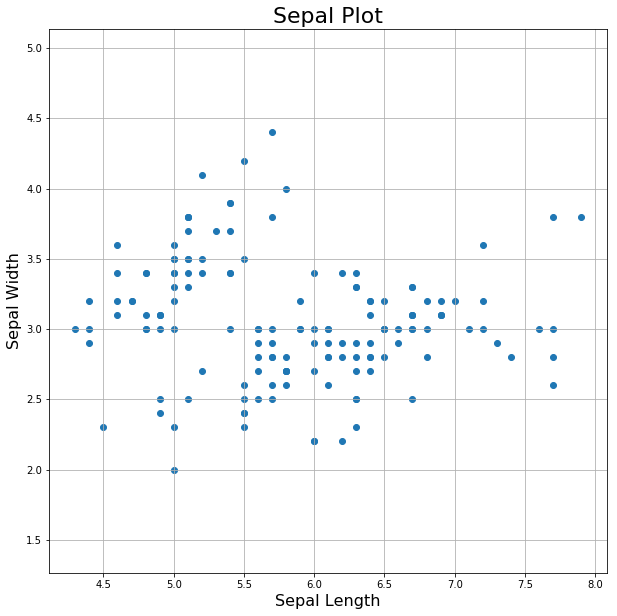

In [7]:
plt.figure(figsize=(10,10))                                    #scatter plot of sepal length vs sepal width           
plt.scatter(list(df.iloc[:,0]), list(df.iloc[:,1]), marker='o')       
plt.axis('equal')                                                                 
plt.xlabel('Sepal Length', fontsize=16)                                                 
plt.ylabel('Sepal Width', fontsize=16)                                                 
plt.title('Sepal Plot', fontsize=22)                                            
plt.grid()                                                                         
plt.show()

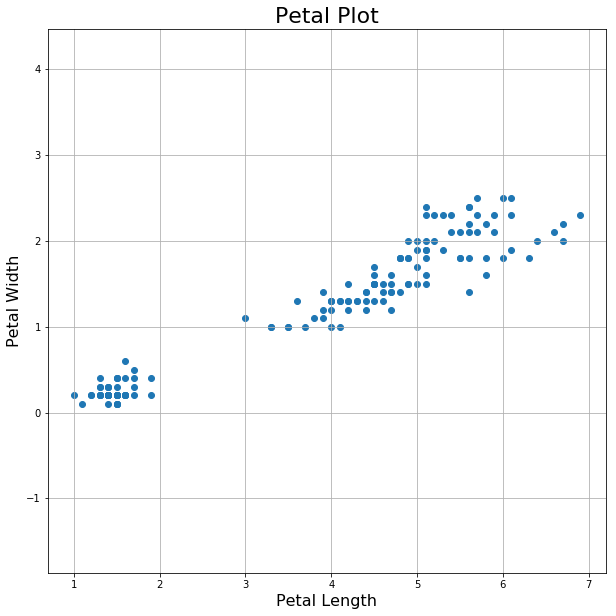

In [8]:
plt.figure(figsize=(10,10))                                        #scatter plot of petal length vs sepal width       
plt.scatter(list(df.iloc[:,2]), list(df.iloc[:,3]), marker='o')       
plt.axis('equal')                                                                 
plt.xlabel('Petal Length', fontsize=16)                                                 
plt.ylabel('Petal Width', fontsize=16)                                                 
plt.title('Petal Plot', fontsize=22)                                            
plt.grid()                                                                         
plt.show()

In [9]:
#Calculating the accuracy
# P.S. The accuracy calculation is for iris data only
def accuracy(cluster_labels, class_labels):
    correct_pred = 0
    
    seto = max(set(labels[0:50]), key=labels[0:50].count)
    vers = max(set(labels[50:100]), key=labels[50:100].count)
    virg = max(set(labels[100:]), key=labels[100:].count)
    
    for i in range(len(df)):
        if cluster_labels[i] == seto and class_labels[i] == 'Iris-setosa':
            correct_pred = correct_pred + 1
        if cluster_labels[i] == vers and class_labels[i] == 'Iris-versicolor' and vers!=seto:
            correct_pred = correct_pred + 1
        if cluster_labels[i] == virg and class_labels[i] == 'Iris-virginica' and virg!=seto and virg!=vers:
            correct_pred = correct_pred + 1
            
    accuracy = (correct_pred/len(df))*100
    return accuracy

In [10]:
def initializeMembershipMatrix(): # initializing the membership matrix
    membership_mat = []
    for i in range(n):
        random_num_list = [random.random() for i in range(k)]
        summation = sum(random_num_list)
        temp_list = [x/summation for x in random_num_list]
        
        flag = temp_list.index(max(temp_list))
        for j in range(0,len(temp_list)):
            if(j == flag):
                temp_list[j] = 1
            else:
                temp_list[j] = 0
        
        membership_mat.append(temp_list)
    return membership_mat

In [11]:
def calculateClusterCenter(membership_mat): # calculating the cluster center
    cluster_mem_val = list(zip(*membership_mat))
    cluster_centers = []
    for j in range(k):
        x = list(cluster_mem_val[j])
        xraised = [e ** m for e in x]
        denominator = sum(xraised)
        temp_num = []
        for i in range(n):
            data_point = list(df.iloc[i])
            prod = [xraised[i] * val for val in data_point]
            temp_num.append(prod)
        numerator = map(sum, list(zip(*temp_num)))
        center = [z/denominator for z in numerator]
        cluster_centers.append(center)
    return cluster_centers

In [12]:
def update_A(membership_mat, cluster_centers): # Updating the A value
    #S-calculation
    cluster_mem_val = list(zip(*membership_mat)) #u pow m
    xraise_lis = []
    mat_lis = []
    for j in range(k):
        x = list(cluster_mem_val[j])
        xraised = [e ** m for e in x]
        xraise_lis.append(xraised)

    #x-v
    S1,S2,S3 = [],[],[]
    S1_t,S2_t,S3_t = [],[],[]
    for i in range(n):
        x = list(df.iloc[i])

        s1 = list(map(operator.sub, x, cluster_centers[0]))
        S1.append(s1)

        s2 = list(map(operator.sub, x, cluster_centers[1]))
        S2.append(s2)

        s3 = list(map(operator.sub, x, cluster_centers[2]))
        S3.append(s3)

    #(x-v)T
    S1 = np.array(S1)
    S1_t = np.transpose(S1)
    S2 = np.array(S2)
    S2_t = np.transpose(S2)
    S3 = np.array(S3)
    S3_t = np.transpose(S3)

    #Second term
    S1_p2 = np.dot(S1_t,S1)
    S2_p2 = np.dot(S2_t,S2)
    S3_p2 = np.dot(S3_t,S3)

    #final s values
    S1_final = np.zeros((4,4))
    S2_final = np.zeros((4,4))
    S3_final = np.zeros((4,4))

    for i in range(0,len(xraise_lis)):
        for j in range(0,len(xraise_lis[i])):
            if(i==0):
                temp = np.dot(xraise_lis[i][j], S1_p2)
                S1_final = np.add(S1_final,temp)
            if(i==1):
                temp = np.dot(xraise_lis[i][j], S2_p2)
                S2_final = np.add(S2_final,temp)
            if(i==2):
                temp = np.dot(xraise_lis[i][j], S3_p2)
                S3_final = np.add(S3_final,temp)

    #A matrix
    A1 = np.dot(math.pow(rho * np.linalg.det(S1_final), float(1/(len(features)))),inv(S1_final))
    A2 = np.dot(math.pow(rho * np.linalg.det(S2_final), float(1/(len(features)))),inv(S2_final))
    A3 = np.dot(math.pow(rho * np.linalg.det(S3_final), float(1/(len(features)))),inv(S3_final))
    
    return A1,A2,A3

In [13]:
def updateMembershipValue(membership_mat, cluster_centers, A): # Updating the membership value
    p = float(2/(m-1))
    for i in range(n):
        x = list(df.iloc[i])
        #distances = [np.linalg.norm(np.array(list(map(operator.sub, x, cluster_centers[j])))) for j in range(k)]
        distances = [np.dot(np.dot(np.transpose(np.array(list(map(operator.sub, x, cluster_centers[j])))),A[j]),
                            np.array(list(map(operator.sub, x, cluster_centers[j])))) for j in range(k)]
        for j in range(k):
            den = sum([math.pow(float(distances[j]/distances[c]), p) for c in range(k)])
            membership_mat[i][j] = float(1/den)      
    return membership_mat

In [14]:
def getClusters(membership_mat): # getting the clusters
    cluster_labels = list()
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels

In [15]:
def gkFCMClustering(): #Second Iteration Multivariate Gaussian
    # Membership Matrix
    membership_mat = initializeMembershipMatrix()
    curr = 0
    acc=[]
    
    mean = [0, 0]
    cov = [[1, 0], [0, 1]]
    
    lis1,cent_temp=[],[]
    
    for i in range(0,k):
        Z = list(np.random.multivariate_normal(mean, cov))
        Z1 = list(np.random.multivariate_normal(mean, cov))
        lis1 = Z+Z1
        cent_temp.append(lis1)
    
    
    while curr < MAX_ITER:
        if(curr == 0):
            cluster_centers = cent_temp
            A = [np.identity(len(features)).tolist(),np.identity(len(features)).tolist(),np.identity(len(features)).tolist()]
            membership_mat = updateMembershipValue(membership_mat, cluster_centers, A)
            print("Cluster Centers:")
            print(np.array(cluster_centers))
            
        else:
            cluster_centers = calculateClusterCenter(membership_mat)
            A1, A2, A3 = update_A(membership_mat, cluster_centers)
            A = [A1,A2,A3]
            membership_mat = updateMembershipValue(membership_mat, cluster_centers, A)
        #cluster_centers = calculateClusterCenter(membership_mat)
        #membership_mat = updateMembershipValue(membership_mat, cluster_centers)
        cluster_labels = getClusters(membership_mat)
        acc.append(cluster_labels)
        curr += 1
    print("---------------------------")
    print("Membership Matrix:")
    print(np.array(membership_mat))
    return cluster_labels, cluster_centers, acc

In [16]:
def gkFCMClustering(): #Third iteration Random vectors from data
    # Membership Matrix
    membership_mat = initializeMembershipMatrix()
    curr = 0
    acc=[]
    #A_temp = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
    #A_temp = np.identity(len(features)).tolist()
    
    while curr < MAX_ITER:
        cluster_centers = calculateClusterCenter(membership_mat)
        if(curr == 0):
            A = [np.identity(len(features)).tolist(),np.identity(len(features)).tolist(),np.identity(len(features)).tolist()]
            membership_mat = updateMembershipValue(membership_mat, cluster_centers, A)
            print("Cluster Centers:")
            print(np.array(cluster_centers))
        else:
            A1, A2, A3 = update_A(membership_mat, cluster_centers)
            A = [A1,A2,A3]
            membership_mat = updateMembershipValue(membership_mat, cluster_centers, A)
        cluster_labels = getClusters(membership_mat)
        acc.append(cluster_labels)
        curr += 1
    print("---------------------------")
    print("Partition matrix:")
    print(np.array(membership_mat))
    return cluster_labels, cluster_centers, acc

In [17]:
labels, centers, acc = gkFCMClustering()
a = accuracy(labels, class_labels)

Cluster Centers:
[[5.89433962 3.01698113 3.88679245 1.26226415]
 [6.03555556 3.18444444 3.90888889 1.21111111]
 [5.625      2.97884615 3.49807692 1.12307692]]
---------------------------
Partition matrix:
[[1.29944213e-04 1.41781808e-04 9.99728274e-01]
 [6.07240848e-02 7.47779146e-02 8.64498001e-01]
 [3.31635342e-03 3.50457127e-03 9.93179075e-01]
 [3.50459340e-02 3.72306203e-02 9.27723446e-01]
 [1.31778110e-03 1.40924229e-03 9.97272977e-01]
 [4.94974966e-02 5.15790130e-02 8.98923490e-01]
 [3.39598070e-02 3.44815886e-02 9.31558604e-01]
 [3.50277574e-05 3.86986827e-05 9.99926274e-01]
 [1.08387039e-01 1.13279806e-01 7.78333155e-01]
 [2.54880283e-02 3.17088147e-02 9.42803157e-01]
 [1.86657057e-02 2.05700154e-02 9.60764279e-01]
 [2.93649171e-02 3.12574998e-02 9.39377583e-01]
 [4.17080311e-02 5.09563229e-02 9.07335646e-01]
 [7.35942343e-02 7.82836426e-02 8.48122123e-01]
 [1.49083628e-01 1.59312183e-01 6.91604190e-01]
 [1.60680128e-01 1.74147039e-01 6.65172833e-01]
 [9.66026896e-02 1.01570604

In [18]:
acc_lis = []
for i in range(0,len(acc)):
    val = accuracy(acc[i], class_labels)
    acc_lis.append(val)

In [19]:
acc_lis = np.array(acc_lis) #calculating accuracy and std deviation 100 times
print("mean=",np.mean(acc_lis))
print("Std dev=",np.std(acc_lis))

mean= 75.3
Std dev= 6.335350555941372


In [20]:
print("Accuracy = " + str(round(a, 2)))

Accuracy = 79.33


In [21]:
print("Cluster center vectors:") #final cluster centers
print(np.array(centers))

Cluster center vectors:
[[6.14861771 3.00164391 5.01600796 1.91443856]
 [6.4781844  2.80660473 4.86510133 1.49684645]
 [5.06809548 3.36720756 1.69105303 0.33126436]]


# Plotting the data

In [22]:
sepal_df = df_full.iloc[:,0:2]
sepal_df = np.array(sepal_df)

In [23]:
m1 = random.choice(sepal_df)
m2 = random.choice(sepal_df)
m3 = random.choice(sepal_df)
cov1 = np.cov(np.transpose(sepal_df))
cov2 = np.cov(np.transpose(sepal_df))
cov3 = np.cov(np.transpose(sepal_df))

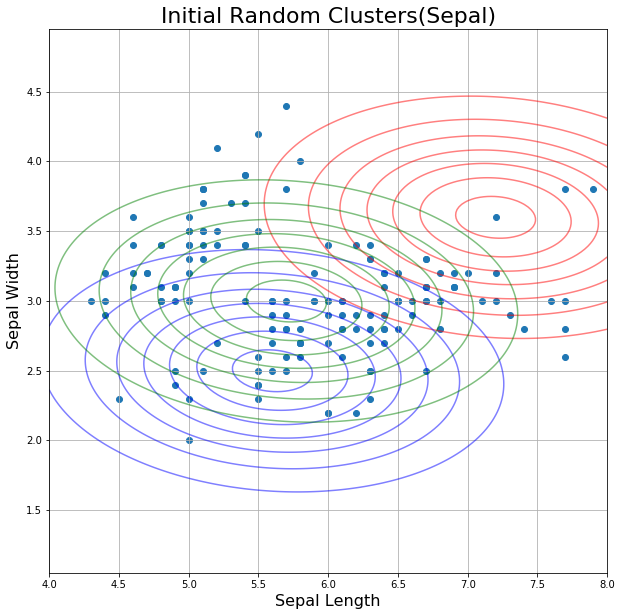

In [24]:
x1 = np.linspace(4,8,150)  
x2 = np.linspace(1.5,4.5,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(m1, cov1)  
Z2 = multivariate_normal(m2, cov2)
Z3 = multivariate_normal(m3, cov3)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(sepal_df[:,0], sepal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('Sepal Length', fontsize=16)                                                  # X-Axis
plt.ylabel('Sepal Width', fontsize=16)                                                  # Y-Axis
plt.title('Initial Random Clusters(Sepal)', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()

In [25]:
petal_df = df_full.iloc[:,2:4]
petal_df = np.array(petal_df)

In [26]:
m1 = random.choice(petal_df)
m2 = random.choice(petal_df)
m3 = random.choice(petal_df)
cov1 = np.cov(np.transpose(petal_df))
cov2 = np.cov(np.transpose(petal_df))
cov3 = np.cov(np.transpose(petal_df))

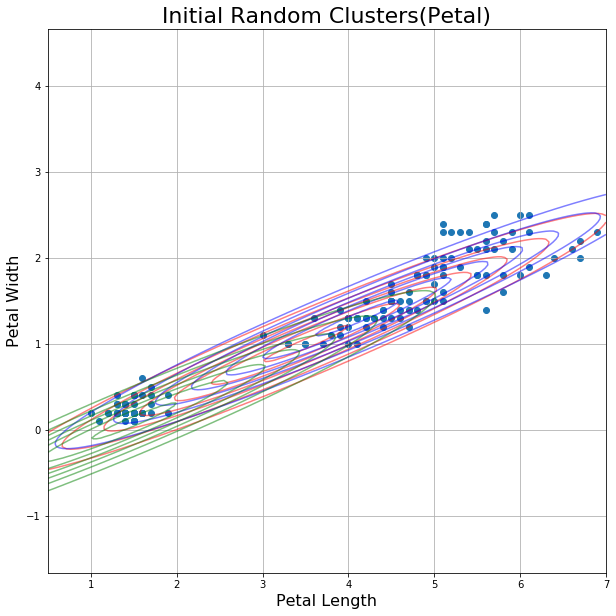

In [27]:
x1 = np.linspace(0.5,7,150)  
x2 = np.linspace(-1,4,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(m1, cov1)  
Z2 = multivariate_normal(m2, cov2)
Z3 = multivariate_normal(m3, cov3)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(petal_df[:,0], petal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('Petal Length', fontsize=16)                                                  # X-Axis
plt.ylabel('Petal Width', fontsize=16)                                                  # Y-Axis
plt.title('Initial Random Clusters(Petal)', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()

In [28]:
#finding mode
seto = max(set(labels[0:50]), key=labels[0:50].count)
vers = max(set(labels[50:100]), key=labels[50:100].count)
virg = max(set(labels[100:]), key=labels[100:].count)

In [29]:
#sepal
s_mean_clus1 = np.array([centers[seto][0],centers[seto][1]])
s_mean_clus2 = np.array([centers[vers][0],centers[vers][1]])
s_mean_clus3 = np.array([centers[virg][0],centers[virg][1]])

In [30]:
values = np.array(labels) #label

#search all 3 species
searchval_seto = seto
searchval_vers = vers
searchval_virg = virg

#index of all 3 species
ii_seto = np.where(values == searchval_seto)[0]
ii_vers = np.where(values == searchval_vers)[0]
ii_virg = np.where(values == searchval_virg)[0]
ind_seto = list(ii_seto)
ind_vers = list(ii_vers)
ind_virg = list(ii_virg)

In [31]:
sepal_df = df_full.iloc[:,0:2]

In [32]:
seto_df = sepal_df[sepal_df.index.isin(ind_seto)]
vers_df = sepal_df[sepal_df.index.isin(ind_vers)]
virg_df = sepal_df[sepal_df.index.isin(ind_virg)]

In [33]:
cov_seto = np.cov(np.transpose(np.array(seto_df)))
cov_vers = np.cov(np.transpose(np.array(vers_df)))
cov_virg = np.cov(np.transpose(np.array(virg_df)))

In [34]:
sepal_df = np.array(sepal_df)

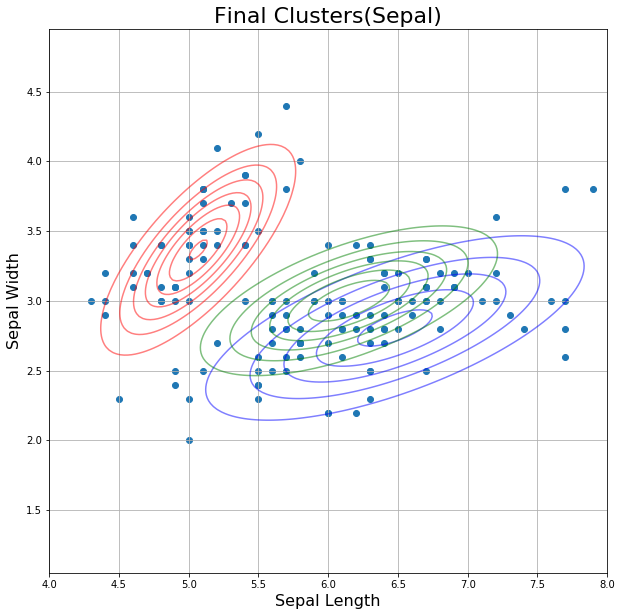

In [35]:
x1 = np.linspace(4,8,150)  
x2 = np.linspace(1.5,4.5,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(s_mean_clus1, cov_seto)  
Z2 = multivariate_normal(s_mean_clus2, cov_vers)
Z3 = multivariate_normal(s_mean_clus3, cov_virg)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(sepal_df[:,0], sepal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('Sepal Length', fontsize=16)                                                  # X-Axis
plt.ylabel('Sepal Width', fontsize=16)                                                  # Y-Axis
plt.title('Final Clusters(Sepal)', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()

In [36]:
#petal
p_mean_clus1 = np.array([centers[seto][2],centers[seto][3]])
p_mean_clus2 = np.array([centers[vers][2],centers[vers][3]])
p_mean_clus3 = np.array([centers[virg][2],centers[virg][3]])

In [37]:
petal_df = df_full.iloc[:,2:4]

In [38]:
seto_df = petal_df[petal_df.index.isin(ind_seto)]
vers_df = petal_df[petal_df.index.isin(ind_vers)]
virg_df = petal_df[petal_df.index.isin(ind_virg)]

In [39]:
cov_seto = np.cov(np.transpose(np.array(seto_df)))
cov_vers = np.cov(np.transpose(np.array(vers_df)))
cov_virg = np.cov(np.transpose(np.array(virg_df)))

In [40]:
petal_df = np.array(petal_df)

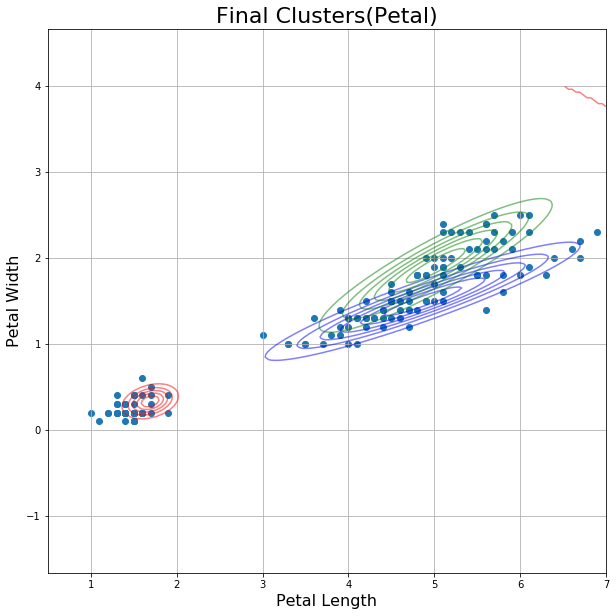

In [41]:
x1 = np.linspace(0.5,7,150)  
x2 = np.linspace(-1,4,150)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(p_mean_clus1, cov_seto)  
Z2 = multivariate_normal(p_mean_clus2, cov_vers)
Z3 = multivariate_normal(p_mean_clus3, cov_virg)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(petal_df[:,0], petal_df[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.contour(X, Y, Z3.pdf(pos), colors="g" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('Petal Length', fontsize=16)                                                  # X-Axis
plt.ylabel('Petal Width', fontsize=16)                                                  # Y-Axis
plt.title('Final Clusters(Petal)', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()